In [1]:
suppressPackageStartupMessages({
  library(cowplot)
  library(dataorganizer)
  library(ggplot2)
  library(ggrastr)

  devtools::load_all()
})

suppressMessages({
  load_arial_font()
})

ℹ Loading cellAdmixNotebooks


In [7]:
# load gut data
data <- prepare_gut_tx_and_meta(rm_small_cells=FALSE, append_regions=TRUE)
cell_annot <- na.omit(data[[1]])
df <- data[[2]]

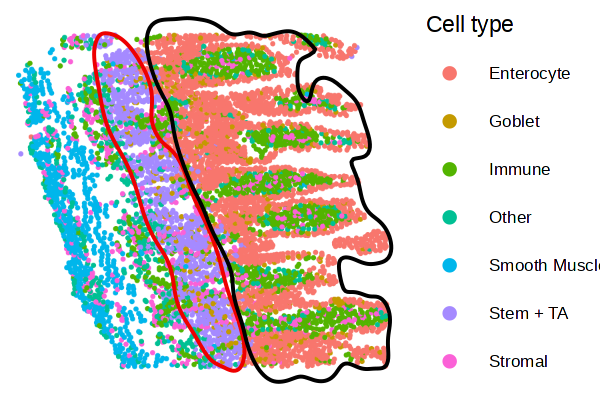

In [11]:
options(repr.plot.width = 3, repr.plot.height = 2, repr.plot.res = 200)

p <- ggplot(cell_annot,aes(x=x,y=y,color=cell_type_coarse)) +
  geom_point_rast(size=.001) +
  #   scale_color_brewer(palette = "Spectral") +
  guides(colour = guide_legend(override.aes = list(size=3)))

conf <- "10%"

cell_annot_sub <- cell_annot[as.character(cell_annot$niche)==2,]

emb <- cell_annot_sub
emb <- emb[,c('x','y')]

kd <- ks::kde(emb, compute.cont=TRUE)
# h <- matrix(c(.05, 0, 0, .05), ncol=2)
# kd <- ks::kde(emb, compute.cont=TRUE, H=h)
lcn <- kd %$% contourLines(x=eval.points[[1]], y=eval.points[[2]], z=estimate, levels=cont[conf]) %>%
  .[[1]] %>% data.frame() %>% cbind(z=1)
cn <- geom_path(aes(x, y), data=lcn, color='red2')

p <- p + cn

conf="1%"

# pair1 <- c(2600,8250)
# pair2 <- c(4000,0)
# y = -5.893x + 23571.8
predicted_y_all <- cell_annot$x * (-5.893) + 23571.8

cell_annot_sub <- cell_annot[as.character(cell_annot$niche) %in% c(3,4) & cell_annot$y>predicted_y_all,]

emb <- cell_annot_sub
emb <- emb[,c('x','y')]

kd <- ks::kde(emb, compute.cont=TRUE)
# h <- matrix(c(.1, 0, 0, .1), ncol=2)
# kd <- ks::kde(emb, compute.cont=TRUE, H=h)
lcn <- kd %$% contourLines(x=eval.points[[1]], y=eval.points[[2]], z=estimate, levels=cont[conf]) %>%
  .[[1]] %>% data.frame() %>% cbind(z=1)
cn <- geom_path(aes(x, y), data=lcn, color='black')

p <- p + cn

p <- p +
  labs(color='Cell type') +
  theme_void() +
  legend_mod +
  theme(text = element_text(family = font_choice),
        legend.text=element_text(size=6),
        legend.title=element_text(size=8))

p

In [12]:
# getting height width ratio to keep aspect ratio accurate in the pdf
x_diff <- max(cell_annot$x) - min(cell_annot$x)
y_diff <- max(cell_annot$y) - min(cell_annot$y)
aspect_ratio <- y_diff / x_diff

width_plot <- 1.25
height_plot <- aspect_ratio * width_plot
print(height_plot)

[1] 2.316355


In [13]:
# pdf(file = "/home/jmitchel/figures/spatial_v2/gut_stemta_region2.pdf", useDingbats = FALSE,
#     width = 3, height = 2)
pdf(OutputPath("gut_stemta_region.pdf"), useDingbats=FALSE, width=width_plot, height=height_plot)
p + theme(legend.position="none")
dev.off()

png 
  2

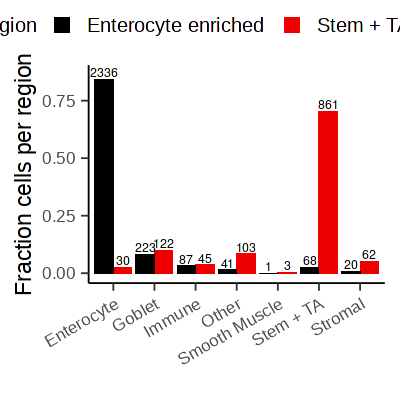

In [16]:
options(repr.plot.width = 2, repr.plot.height = 2, repr.plot.res = 200)

## compute counts of each cell type in each region
cell_annot_stemta <- cell_annot[cell_annot$niche==2,]
ct_counts_stemta <- table(cell_annot_stemta$cell_type_coarse)
cell_annot_other <- cell_annot[cell_annot$niche==3,]
ct_counts_other <- table(cell_annot_other$cell_type_coarse)

c1 <- c(ct_counts_stemta,ct_counts_other)
c2 <- c(names(ct_counts_stemta),names(ct_counts_other))
c3 <- c(rep('Stem + TA enriched',length(ct_counts_stemta)),rep('Enterocyte enriched',length(ct_counts_other)))
ct_fracs <- cbind.data.frame(c1,c2,c3)
colnames(ct_fracs) <- c('counts','cell_type','region')
ct_fracs$cell_type <- as.factor(ct_fracs$cell_type)
ct_fracs$region <- factor(ct_fracs$region,levels=c('Enterocyte enriched','Stem + TA enriched'))
ct_fracs2 <- ct_fracs

total_counts <- table(cell_annot$niche)
ndx1 <- which(names(total_counts)==2)
ndx2 <- which(names(total_counts)==3)
names(total_counts)[ndx1] <- 'Stem + TA enriched'
names(total_counts)[ndx2] <- 'Enterocyte enriched'

match_ndx <- match(ct_fracs2$region,names(total_counts))
ct_fracs2$total_counts <- total_counts[match_ndx]
ct_fracs2$fracs <- ct_fracs2$counts / ct_fracs2$total_counts
p <- ggplot(ct_fracs2,aes(x=cell_type,y=fracs,fill=region)) +
  geom_bar(position = "dodge", stat = "identity") +
  geom_text(aes(label=counts), position=position_dodge(width=0.9), vjust=-0.25, size=(3*geom_text_size)/4) +
  ylim(c(0,max(ct_fracs2$fracs)+.02)) +
  xlab('') +
  ylab('Fraction cells per region') +
  theme_classic(base_line_size = gg_line_thickness) +
  scale_fill_manual(breaks = c('Enterocyte enriched','Stem + TA enriched'),values = c('black','red2')) +
  p_theme +
  theme(axis.text.x = element_text(angle = 30, vjust = 1, hjust=1),
       legend.key.size = unit(7, 'pt'),
        legend.key.height = unit(7, 'pt'),
        legend.key.width = unit(7, 'pt'),
        legend.title=element_text(size=7),
        legend.text=element_text(size=7),
       axis.title.x = element_text(size = 5),
       legend.position="top",
       legend.box="vertical", legend.margin=margin())


p


In [17]:
pdf(OutputPath("gut_cell_counts.pdf"), useDingbats=FALSE, width=2, height=2)
p
dev.off()

png 
  2